In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s : i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()} # dict.items() is good!
print(itos)
vocab_size = len(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # # BatchNorm layer
  # # -------------------------------------------------------------
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3221


In [9]:
hpreact.mean(0, keepdim=True)

tensor([[-4.1351, -1.4333, -2.6204,  5.2466,  1.4428,  2.2342,  2.9207, -3.4029,
         -2.4664,  3.0368,  0.2130, -4.4843,  0.6468,  2.2024,  0.7064,  0.4629,
          3.7851, -4.1523, -1.5622,  4.6506,  0.2982, -0.3983,  2.2651,  1.8642,
          1.2275,  4.0951,  3.1420,  0.3905,  0.4311,  2.4423, -0.3463, -0.6762,
          0.5576, -0.5290, -1.7203, -3.4642, -1.0341, -2.1031,  0.3022,  1.9227,
         -0.0510, -3.9018, -0.7374, -2.9385,  0.1878, -0.7136,  1.1751, -1.7285,
          2.4909,  2.0460, -0.4769, -0.9861,  2.3577,  2.5508,  0.3195, -1.8302,
          0.9613,  4.4983,  1.4466,  0.6593, -0.2733,  1.0145,  0.1062, -0.0854,
          1.5539,  1.1577,  2.5708, -0.1042, -0.8439, -0.6123,  1.8896, -0.0814,
          2.3946, -3.1007, -4.3271, -0.5682,  4.1782, -1.2720, -0.6384, -0.0493,
          3.1676,  3.9681,  1.4389,  2.2492,  1.7030, -0.0594, -2.5038, -0.6407,
         -0.9404, -1.0191,  2.7870,  2.0640,  0.2476, -0.4240,  0.5599, -1.3291,
         -1.5131, -1.5566,  

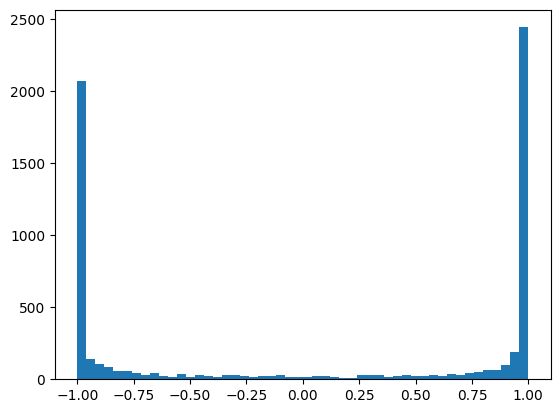

In [10]:
plt.hist(h.view(-1).tolist(), 50);

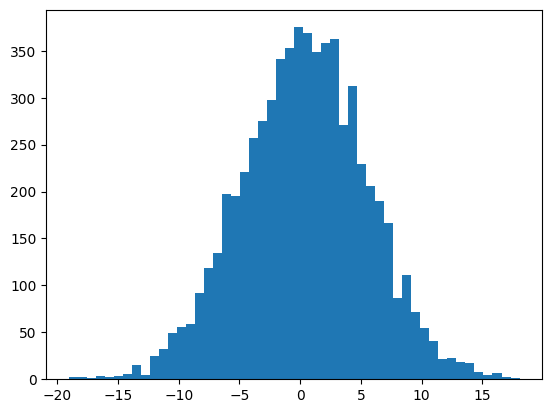

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50);

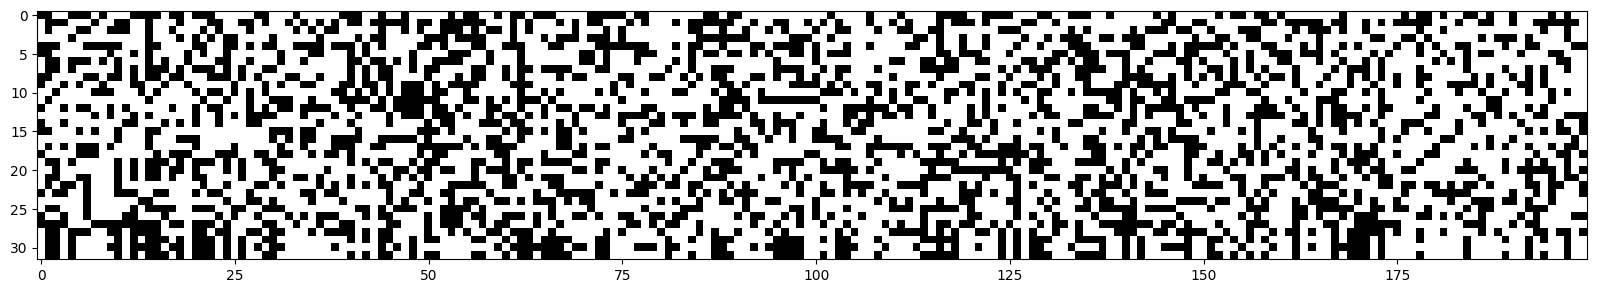

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### BATCHNORM

In [13]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [14]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/  20000: 3.3239
  10000/  20000: 2.0322


In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [22]:
print(bnstd)

tensor([[2.0008, 1.4810, 1.6671, 1.7910, 1.6869, 1.7351, 1.4232, 1.5734, 1.8639,
         1.4721, 1.7399, 1.6022, 1.4560, 1.7470, 1.1794, 1.7399, 2.1854, 1.4040,
         1.8741, 1.8442, 1.6722, 1.9837, 1.5612, 1.8567, 1.3972, 1.5739, 1.4172,
         1.6807, 1.7542, 1.9140, 1.2738, 1.2344, 2.0164, 1.3541, 1.6642, 1.6539,
         2.2768, 1.7027, 1.6136, 1.6612, 1.5327, 1.5537, 1.8308, 1.7614, 1.4715,
         1.4531, 1.6414, 1.7107, 1.4180, 1.9189, 1.4955, 1.4364, 1.3112, 1.6264,
         1.9014, 1.7010, 1.3968, 1.8405, 2.2667, 1.4225, 1.5082, 1.5121, 1.4339,
         1.5757, 2.0610, 1.7950, 1.5034, 1.7269, 1.6758, 1.8400, 1.6910, 1.6195,
         1.3735, 1.3754, 1.3366, 1.3386, 1.9427, 1.7830, 1.4699, 1.6707, 1.7938,
         1.4042, 1.5134, 1.9426, 1.9970, 1.6623, 1.4428, 1.8646, 1.7669, 1.7492,
         1.4432, 1.5467, 1.7193, 2.0646, 1.9727, 1.4853, 1.7247, 1.4780, 1.4019,
         1.6975, 1.5105, 1.8268, 1.8612, 1.4589, 1.3975, 1.5896, 1.4738, 1.3582,
         1.6995, 1.8102, 1.6

In [23]:
bnstd_running

tensor([[1.9775, 1.4438, 1.6313, 1.7629, 1.6748, 1.6955, 1.3810, 1.5612, 1.8193,
         1.4245, 1.7214, 1.5593, 1.4287, 1.7257, 1.1667, 1.6908, 2.1570, 1.3780,
         1.8299, 1.8353, 1.6564, 1.9424, 1.5326, 1.8295, 1.3623, 1.5532, 1.3884,
         1.6408, 1.7466, 1.8941, 1.2500, 1.2063, 2.0065, 1.3372, 1.6377, 1.6425,
         2.2212, 1.7079, 1.5913, 1.6599, 1.5061, 1.5434, 1.7759, 1.7482, 1.4428,
         1.4334, 1.6009, 1.6409, 1.3921, 1.8845, 1.4835, 1.4202, 1.3041, 1.6145,
         1.8516, 1.6734, 1.3808, 1.8316, 2.2386, 1.4083, 1.4766, 1.4915, 1.4088,
         1.5496, 2.0563, 1.7846, 1.4940, 1.6968, 1.6614, 1.8322, 1.6776, 1.6302,
         1.3508, 1.3421, 1.3157, 1.3189, 1.9402, 1.7644, 1.4390, 1.6343, 1.7920,
         1.3758, 1.4921, 1.9403, 1.9622, 1.6531, 1.4240, 1.8171, 1.7715, 1.7074,
         1.4328, 1.5505, 1.6893, 2.0643, 1.9797, 1.4421, 1.7184, 1.4493, 1.3659,
         1.6876, 1.5015, 1.8062, 1.8587, 1.4300, 1.3985, 1.5778, 1.4645, 1.3230,
         1.6791, 1.7878, 1.6

In [53]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [54]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.5 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


#### activation statistics for forward pass and backward pass

layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.12%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 2.91%
layer 8 (      Tanh): mean -0.03, std 0.63, saturated: 2.75%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.88%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%


Text(0.5, 1.0, 'activation distribution')

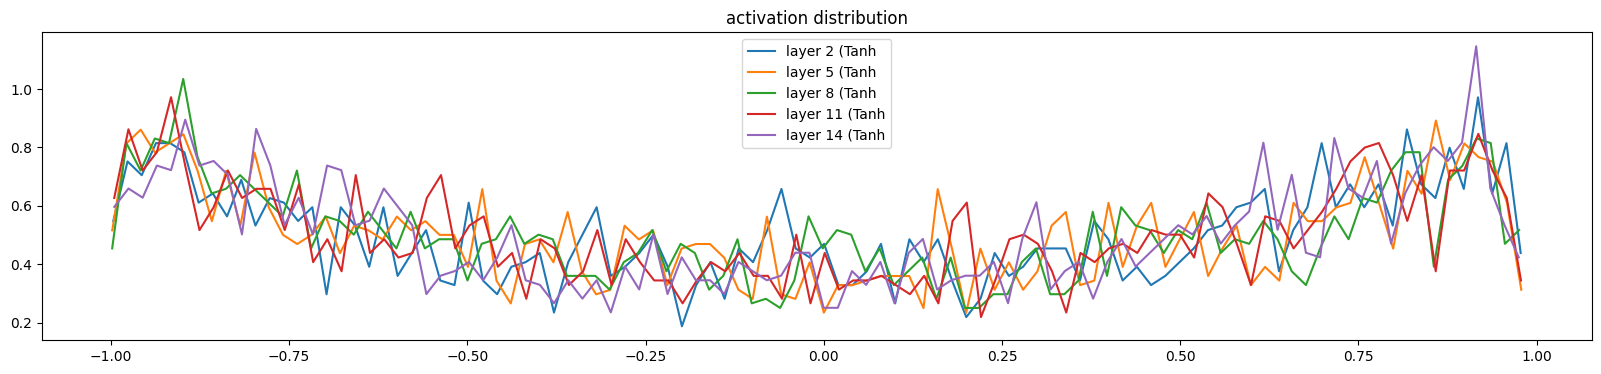

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 4.878380e-03
layer 5 (      Tanh): mean +0.000000, std 4.204228e-03
layer 8 (      Tanh): mean -0.000000, std 3.840915e-03
layer 11 (      Tanh): mean +0.000000, std 3.623791e-03
layer 14 (      Tanh): mean -0.000000, std 3.463282e-03


Text(0.5, 1.0, 'gradient distribution')

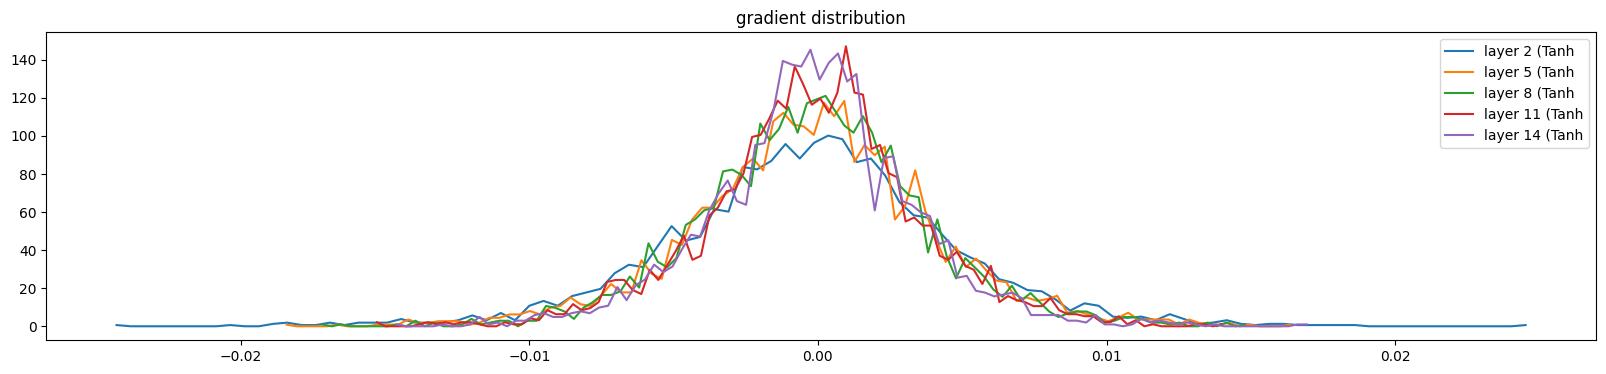

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

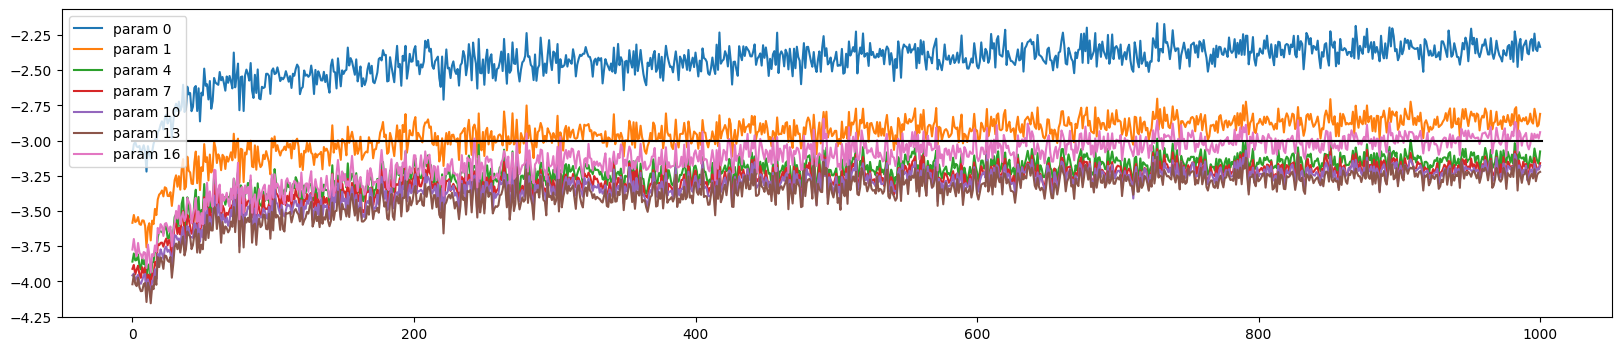

In [57]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # this means not including bias. just see the weights
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [46]:
for i,p in enumerate(parameters):
    print(p.shape)

torch.Size([27, 10])
torch.Size([30, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 27])
torch.Size([27])
